In [3]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

## Beginning of the Titanic dataset
Of course, first of all, the dataset is needed. So, we need to import the dataset first. Import the data by using the pandas. <br>Mate, you need to have at least two datasets(train and test). If you have three datasets, that's better because it can be use as validation dataset which can check the overfit and underfit.

In [4]:
train = pd.read_csv('../datasets/titanic/train.csv')
test = pd.read_csv('../datasets/titanic/eval.csv')

The important thing is that we need to understand the how the datasets is created. Therefore, we need to peek in to the dataset with the features of pandas. We can see simple dataset, in survived 0=dead and 1=alive.
- head() function = taking first 5 columns of csv file. 😉


In [7]:
# FOR TRAIN
train.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [8]:
# FOR TEST
test.drop(['survived'], axis = 1, inplace = True)
test.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,male,54.0,0,0,51.8625,First,E,Southampton,y
2,female,58.0,0,0,26.5500,First,C,Southampton,y
3,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,male,34.0,0,0,13.0000,Second,D,Southampton,y


## Checking the datatypes of datasets 
Don't want to skip the step, mate. Datatypes are very important in both machine learing and deep learning. Therefore,
1. First, check the datatypes 📊.
2. Second, if there is null or NAN or EMPTY or INFINIITY, we need to cleanse that dirty data 🗑.

In [9]:
# no dirty data in TRAIN
# train['your column name'].isnull().values.any() # this is for individual column
train.isnull().values.any() # this is checking entire dataframe
print(train.isnull().sum()) # if there is NaN, check the sum of NaN
train.info()
train['deck'].unique()

survived              0
sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare                627 non-null    float64
 6   class               627 non-null    object 
 7   deck                627 non-null    object 
 8   embark_town         627 non-null    object 
 9   alone               627 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 

array(['unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'], dtype=object)

In [10]:
# no dirty data in TRAIN
# train['your column name'].isnull().values.any() # this is for individual column
test.isnull().values.any() # this is checking entire dataframe
print(test.isnull().sum()) # if there is NaN, check the sum of NaN
test['deck'].unique()

sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64


array(['unknown', 'E', 'C', 'D', 'F', 'B', 'A'], dtype=object)

## Now let's try to understand the data 
First of all, let's draw some charts which will automatically generate by the seaborn library 😉. You just needs to modify the hue parameter values to what you want to emphasize <br>
This is reference link : https://www.kaggle.com/saife245/titanic-deep-learning-model-with-80-accuracy?scriptVersionId=40074641&cellId=30

D:\python 3.9.5\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


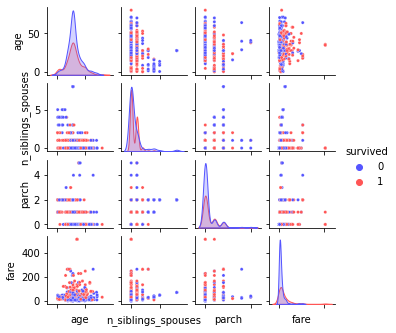

In [11]:
g = sns.pairplot(data=train, hue='survived', palette = 'seismic',
                 size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

## Feature Engineering 
Yo! no, no, it is just nothing. Hear me out. It's just a big word "FEATURE ENGINEERING"😑.<br> It's actually remodify the including data into more understandable data. I will show you. It's easy😉. 

### Before doing any FEATURE ENGINEERING.
Let's check what data can be remodified into more understandable data. In my eye, i just see AGE, right?<br>
- We can change into "Child, Teenager, Adult, Old".
- And then, i can also tweak "n_sibling_spouses, parch" and also "fare"?

In [12]:
# Okay, first of all, let's combine two data into one.
all_data = [train,test]

Below there, there are bin functions which are spliting value dealingg with labels function to split nice and clean 👍.

In [13]:
for dataset in all_data:
     dataset['FamilySize'] = dataset['n_siblings_spouses']+dataset['parch']+1

for dataset in all_data:
     dataset['Age_Range'] = pd.cut(dataset['age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

for dataset in all_data:
    dataset['Fare_Range'] = pd.cut(dataset['fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])
print(all_data)

[     survived     sex   age  n_siblings_spouses  parch     fare   class  \
0           0    male  22.0                   1      0   7.2500   Third   
1           1  female  38.0                   1      0  71.2833   First   
2           1  female  26.0                   0      0   7.9250   Third   
3           1  female  35.0                   1      0  53.1000   First   
4           0    male  28.0                   0      0   8.4583   Third   
..        ...     ...   ...                 ...    ...      ...     ...   
622         0    male  28.0                   0      0  10.5000  Second   
623         0    male  25.0                   0      0   7.0500   Third   
624         1  female  19.0                   0      0  30.0000   First   
625         0  female  28.0                   1      2  23.4500   Third   
626         0    male  32.0                   0      0   7.7500   Third   

        deck  embark_town alone  FamilySize Age_Range    Fare_Range  
0    unknown  Southampton   

Now our feature engineering is finished and we need to move on the data backup. Let's recall the train and test from above.

In [14]:
# backing up dataset not to lose data
train_bup = train
test_bup = test
#test_bup.drop(['survived'], axis = 1, inplace = True)
test_bup.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone,FamilySize,Age_Range,Fare_Range
0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y,1,Adult,median_fare
1,male,54.0,0,0,51.8625,First,E,Southampton,y,1,Elder,high_fare
2,female,58.0,0,0,26.5500,First,C,Southampton,y,1,Elder,Average_fare
3,female,55.0,0,0,16.0000,Second,unknown,Southampton,y,1,Elder,Average_fare
4,male,34.0,0,0,13.0000,Second,D,Southampton,y,1,Adult,median_fare


In [15]:
all_bup_data = [train_bup,test_bup]

## Now let's get rid of the unnecessary columns "age, fare,"

In [16]:
for i in all_bup_data:
    drop_column = ['age', 'fare']
    i.drop(drop_column, axis = 1, inplace = True)

In [17]:
all_bup_data

[     survived     sex  n_siblings_spouses  parch   class     deck  \
 0           0    male                   1      0   Third  unknown   
 1           1  female                   1      0   First        C   
 2           1  female                   0      0   Third  unknown   
 3           1  female                   1      0   First        C   
 4           0    male                   0      0   Third  unknown   
 ..        ...     ...                 ...    ...     ...      ...   
 622         0    male                   0      0  Second  unknown   
 623         0    male                   0      0   Third  unknown   
 624         1  female                   0      0   First        B   
 625         0  female                   1      2   Third  unknown   
 626         0    male                   0      0   Third  unknown   
 
      embark_town alone  FamilySize Age_Range    Fare_Range  
 0    Southampton     n           2     Adult      Low_fare  
 1      Cherbourg     n           

## Now let's go to another step. 
- We mixed train_bup and test_bup but it can be separated by calling each variables. And later we will going to check correlation 😉. 
- LoL, it's nothing. Let me show. Now, let's do the things.

## Adding dummy's data by .get_dummies() functions.
In this step, we will convert the normal categorical data into simple that can read by computer. That's important computer only know number such 1,2,0.1,0.2,12,100 and etc. So this function will simply divide the data into machine readable form. There are lots of tool to change the complex data into simple data. Now, we will use the .get_dummies function from pandas. We will going to change those columns. 
- class, deck, alone, sex, Age_Range, emabark_town, Fare_Range

In [18]:
# this is for test data
testdf = pd.get_dummies(test_bup, columns = ['class', 'deck', 'alone', 'sex', 'Age_Range', 'embark_town', 'Fare_Range'],
                        prefix= ['class', 'deck', 'alone' ,'sex', 'age_type', 'embark_town', 'fare_type'] )

traindf = pd.get_dummies(train_bup, columns = ['class', 'deck', 'alone', 'sex', 'Age_Range', 'embark_town', 'Fare_Range'],
                        prefix= ['class', 'deck', 'alone' ,'sex', 'age_type', 'embark_town', 'fare_type'] )
testdf.head()

,n_siblings_spouses,parch,FamilySize,class_First,class_Second,class_Third,deck_A,deck_B,deck_C,deck_D,...,age_type_Adult,age_type_Elder,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_unknown,fare_type_Low_fare,fare_type_median_fare,fare_type_Average_fare,fare_type_high_fare
0,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2,0,0,1,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
4,0,0,1,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,1,0,0


In [19]:
# adding deck_G to the test data because it is missing.
deckG = traindf['deck_G']
testdf['deck_G'] = deckG
print(traindf.isnull().sum())
print(testdf.isnull().sum())

survived                   0
n_siblings_spouses         0
parch                      0
FamilySize                 0
class_First                0
class_Second               0
class_Third                0
deck_A                     0
deck_B                     0
deck_C                     0
deck_D                     0
deck_E                     0
deck_F                     0
deck_G                     0
deck_unknown               0
alone_n                    0
alone_y                    0
sex_female                 0
sex_male                   0
age_type_Children          0
age_type_Teenage           0
age_type_Adult             0
age_type_Elder             0
embark_town_Cherbourg      0
embark_town_Queenstown     0
embark_town_Southampton    0
embark_town_unknown        0
fare_type_Low_fare         0
fare_type_median_fare      0
fare_type_Average_fare     0
fare_type_high_fare        0
dtype: int64
n_siblings_spouses         0
parch                      0
FamilySize                 0
c

## NOW IT'S TIME TO CHECK CORRELATION

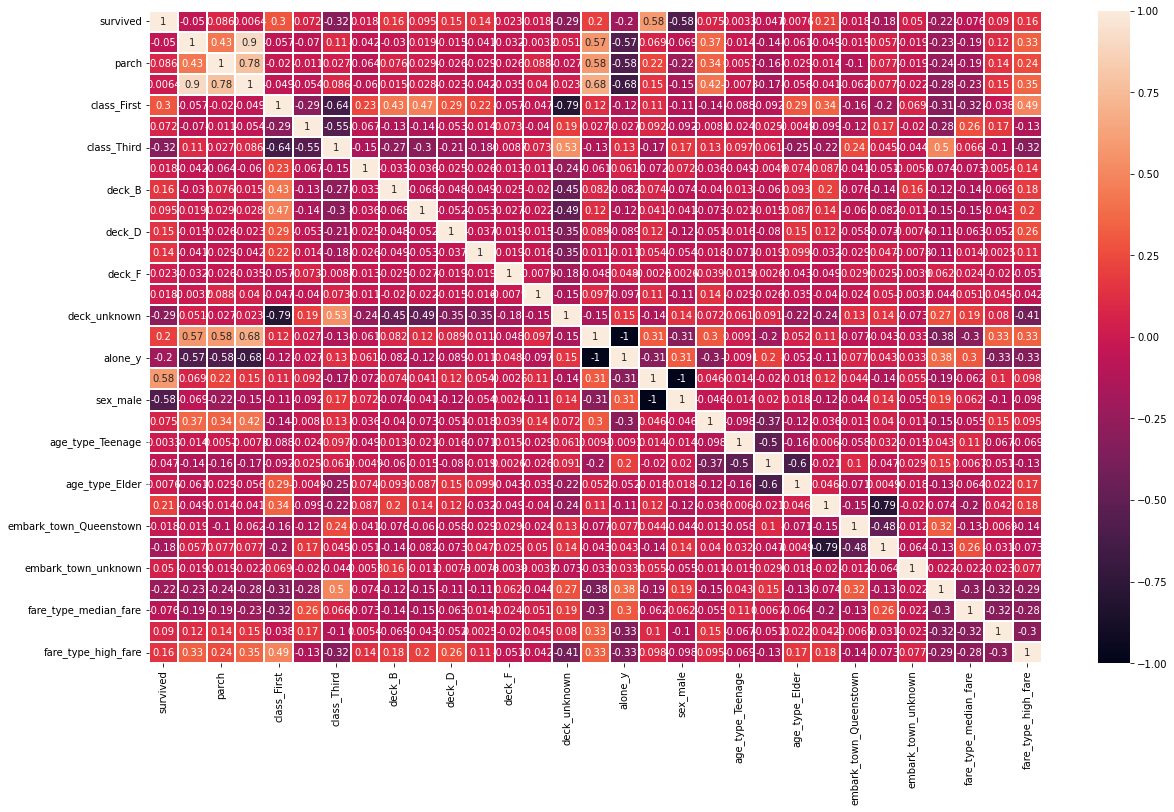

In [20]:
sns.heatmap(traindf.corr(),annot=True,linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

## NOW and finally MODEL CREATION STEP
In this step, we will select input feature and output feature for the neural network.

In [21]:
target = traindf['survived'].values
features = traindf[['n_siblings_spouses', 'parch', 'FamilySize', 'class_First',
       'class_Second', 'class_Third', 'deck_A', 'deck_B', 'deck_C', 'deck_D',
       'deck_E', 'deck_F', 'deck_G', 'deck_unknown', 'alone_n', 'alone_y',
       'sex_female', 'sex_male', 'age_type_Children', 'age_type_Teenage',
       'age_type_Adult', 'age_type_Elder', 'embark_town_Cherbourg',
       'embark_town_Queenstown', 'embark_town_Southampton',
       'embark_town_unknown', 'fare_type_Low_fare', 'fare_type_median_fare',
       'fare_type_Average_fare', 'fare_type_high_fare']].values

In [22]:
a = ['n_siblings_spouses', 'parch', 'FamilySize', 'class_First',
       'class_Second', 'class_Third', 'deck_A', 'deck_B', 'deck_C', 'deck_D',
       'deck_E', 'deck_F', 'deck_G', 'deck_unknown', 'alone_n', 'alone_y',
       'sex_female', 'sex_male', 'age_type_Children', 'age_type_Teenage',
       'age_type_Adult', 'age_type_Elder', 'embark_town_Cherbourg',
       'embark_town_Queenstown', 'embark_town_Southampton',
       'embark_town_unknown', 'fare_type_Low_fare', 'fare_type_median_fare',
       'fare_type_Average_fare', 'fare_type_high_fare']

b = ['n_siblings_spouses', 'parch', 'FamilySize', 'class_First',
       'class_Second', 'class_Third', 'deck_A', 'deck_B', 'deck_C', 'deck_D',
       'deck_E', 'deck_F', 'deck_unknown', 'alone_n', 'alone_y', 'sex_female',
       'sex_male', 'age_type_Children', 'age_type_Teenage', 'age_type_Adult',
       'age_type_Elder', 'embark_town_Cherbourg', 'embark_town_Queenstown',
       'embark_town_Southampton', 'embark_town_unknown', 'fare_type_Low_fare',
       'fare_type_median_fare', 'fare_type_Average_fare',
       'fare_type_high_fare']
print(len(b))

29


In [23]:
keras.backend.clear_session()
model = Sequential()
model.add(Dense(activation='relu', input_dim=30, units=11, kernel_initializer='uniform'))
model.add(Dense(activation='relu', units=11, kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(activation='relu', units=11, kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Dense(activation='relu', units=5, kernel_initializer='uniform'))
model.add(Dense(activation='sigmoid', units=1, kernel_initializer='uniform'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                341       
_________________________________________________________________
dense_1 (Dense)              (None, 11)                132       
_________________________________________________________________
dropout (Dropout)            (None, 11)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                132       
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 60        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6

# It's TIME for TRAINING DATA BOISSS!
Let's watch the delicious epoch training for train data.

In [24]:
training=model.fit(features,
                    target,
                    batch_size = 10,
                    epochs = 100,
                    validation_split=0.1,
                    verbose = 2,
                    shuffle=True)

Epoch 1/100
57/57 - 1s - loss: 0.6917 - accuracy: 0.6011 - val_loss: 0.6888 - val_accuracy: 0.6349
Epoch 2/100
57/57 - 0s - loss: 0.6876 - accuracy: 0.6099 - val_loss: 0.6804 - val_accuracy: 0.6349
Epoch 3/100
57/57 - 0s - loss: 0.6664 - accuracy: 0.6099 - val_loss: 0.6079 - val_accuracy: 0.6349
Epoch 4/100
57/57 - 0s - loss: 0.6090 - accuracy: 0.6099 - val_loss: 0.5182 - val_accuracy: 0.6349
Epoch 5/100
57/57 - 0s - loss: 0.5932 - accuracy: 0.6099 - val_loss: 0.5084 - val_accuracy: 0.6349
Epoch 6/100
57/57 - 0s - loss: 0.5669 - accuracy: 0.6667 - val_loss: 0.4636 - val_accuracy: 0.8889
Epoch 7/100
57/57 - 0s - loss: 0.5729 - accuracy: 0.7447 - val_loss: 0.4548 - val_accuracy: 0.8571
Epoch 8/100
57/57 - 0s - loss: 0.5480 - accuracy: 0.7766 - val_loss: 0.4326 - val_accuracy: 0.8730
Epoch 9/100
57/57 - 0s - loss: 0.5245 - accuracy: 0.7872 - val_loss: 0.4118 - val_accuracy: 0.8730
Epoch 10/100
57/57 - 0s - loss: 0.5090 - accuracy: 0.7961 - val_loss: 0.3888 - val_accuracy: 0.8889
Epoch 11/

## Final Countdown 
This is the final step of analysis of titanic data. For the final prediction, we will use simple .predict() function. All the predicted output will be lot of float number. Therefore, we need to round the number by python function, .round().

In [25]:
prediction = model.predict(testdf)
final = prediction.round()
final

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],

## Last but not least
We will be going to concatenate the actual output from the origin survived and predict survived by .concat().

In [29]:
prediction = pd.DataFrame(final, columns=['predicted_survived'])
test = pd.read_csv('../datasets/titanic/eval.csv')
prediction = pd.concat((test.iloc[:, 0], prediction), axis = 1)
prediction.to_csv('titanic_output.csv', sep=">", index = False)
test.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y
